# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -p numpy,pandas,matplotlib,seaborn,statsmodels,sklearn,scipy

numpy      : 1.21.5
pandas     : 1.4.4
matplotlib : 3.5.2
seaborn    : 0.11.2
statsmodels: 0.13.2
sklearn    : 1.0.2
scipy      : 1.9.1



In [4]:
# Carregando os dados
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada.     
 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [6]:
# Criando função
def func_bivariada(df, resposta, explicativa):
    tab = pd.crosstab(df[explicativa], df[resposta], margins = True)
    tab['percentual'] = tab[1] / tab['All']
    tab['Odds'] = tab['percentual'] / (1 - tab['percentual'])
    tab['Odds_ratio'] = tab['Odds']/tab.loc['All','Odds']
    tab['Logito'] = np.log(tab['Odds'])
    tab['WOE'] = np.log(tab['Odds_ratio'])
    return tab

In [7]:
# Aplicando a func_bivariada
tab_sex = func_bivariada(df = df, resposta = 'flag_doente', explicativa = 'sex')
tab_sex

flag_doente,0,1,All,percentual,Odds,Odds_ratio,Logito,WOE
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [8]:
tab_fbs = func_bivariada(df = df, resposta = 'flag_doente', explicativa = 'fbs')
tab_fbs

flag_doente,0,1,All,percentual,Odds,Odds_ratio,Logito,WOE
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [9]:
tab_exang= func_bivariada(df = df, resposta = 'flag_doente', explicativa = 'exang')
tab_exang

flag_doente,0,1,All,percentual,Odds,Odds_ratio,Logito,WOE
exang,,,,,,,,
0.0,141,63,204,0.308824,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,3.304348,3.898655,1.195239,1.360632
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


- A variável `exang` é estatísticamente mais relevante. Ela possui valor 1 (sim) e apresenta maior percentual de doentes , maiores valores de Odds e Logito.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [10]:
# Criando função
def func_bivariada_2(df, resposta, explicativa, num_categorias=5):
    df['grupo'] = pd.qcut(df[explicativa], num_categorias, duplicates='drop')
    tab = pd.crosstab(df['grupo'], df[resposta], margins = True)
    tab['percentual'] = tab[1] / tab['All']
    tab['Odds'] = tab['percentual'] / (1 - tab['percentual'])
    tab['Odds_ratio'] = tab['Odds']/tab.loc['All','Odds']
    tab['Logito'] = np.log(tab['Odds'])
    tab['WOE'] = np.log(tab['Odds_ratio'])
    return tab

In [11]:
# Aplicando func_bivariada_2
tab_age = func_bivariada_2(df=df, resposta='flag_doente', explicativa='age')
tab_age

flag_doente,0,1,All,percentual,Odds,Odds_ratio,Logito,WOE
grupo,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [12]:
df['cp'].value_counts()

4.0    144
3.0     86
2.0     50
1.0     23
Name: cp, dtype: int64

In [13]:
reglog = smf.logit('flag_doente ~ C(sex) + C(cp, Treatment(4)) + trestbps + age', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                  0.3097
Time:                        16:42:15   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -5.8619      1.413     -4.147      0.000      -8.632      -3.092
C(sex)[T.1.0]                  1.8094      0.353      5.130      0.000       1.118       2.501
C(cp, Treatment(4))[T.1.0]    -2.4789      0.553     -4.485      0.000      -3.562      -1.396
C(cp, Treatment(4))[T.2.0]    -2.5406      0.452     -5.622      0.000      -3.426      -1.655
C(cp, Treatment(4))[T.3.0]    -2.4074      0.360     -6.690      0.000      -3.113      -1.702
trestbps                       0.0193      0.009      2.261      0.024       0.003       0.036
age                            0.0567      0.018      3.120      0.002       0.021       0.092
==============================================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [14]:
# Calcular a probabilidade de evento predita segundo o modelo
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,grupo,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(62.0, 77.0]",0.458229
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(62.0, 77.0]",0.944123
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(62.0, 77.0]",0.886566
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(28.999, 45.0]",0.134929
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(28.999, 45.0]",0.027278


In [15]:
# Categorizar essa probabilidade em G=5 grupos
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')
cat_pred.value_counts().sort_index()

(0.0131, 0.143]    62
(0.143, 0.287]     59
(0.287, 0.586]     62
(0.586, 0.822]     59
(0.822, 0.944]     61
Name: predito, dtype: int64

In [16]:
# Calcular a probabilidade de evento predita média por grupo
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns={'flag_doente': 'contagem'})
qualid['predito'] = group_reg['predito'].mean()
qualid

,contagem,predito
predito,,
"(0.0131, 0.143]",62,0.072008
"(0.143, 0.287]",59,0.209626
"(0.287, 0.586]",62,0.435175
"(0.586, 0.822]",59,0.708861
"(0.822, 0.944]",61,0.874819


In [17]:
# Calcular a taxa de eventos (média da variável indicadora de eventos) por grupo
qualid['pct_sobrev'] = group_reg['flag_doente'].mean()
qualid

,contagem,predito,pct_sobrev
predito,,,
"(0.0131, 0.143]",62,0.072008,0.080645
"(0.143, 0.287]",59,0.209626,0.152542
"(0.287, 0.586]",62,0.435175,0.483871
"(0.586, 0.822]",59,0.708861,0.762712
"(0.822, 0.944]",61,0.874819,0.819672


Text(0.5, 0, 'Grupo')

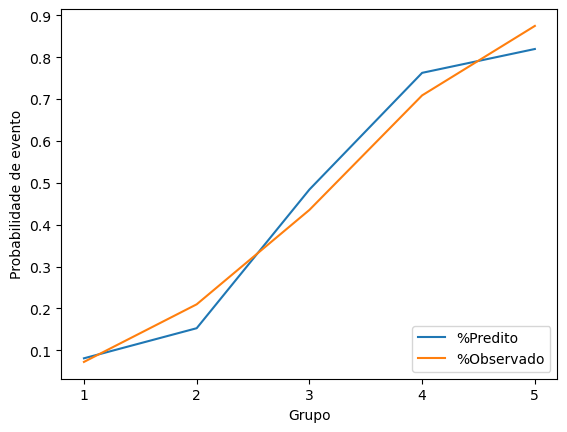

In [18]:
# Comparar graficamente o valor eperado versus observado para a taxa de maus por grupo
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_sobrev'].plot(label='%Predito')
ax = qualid['predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

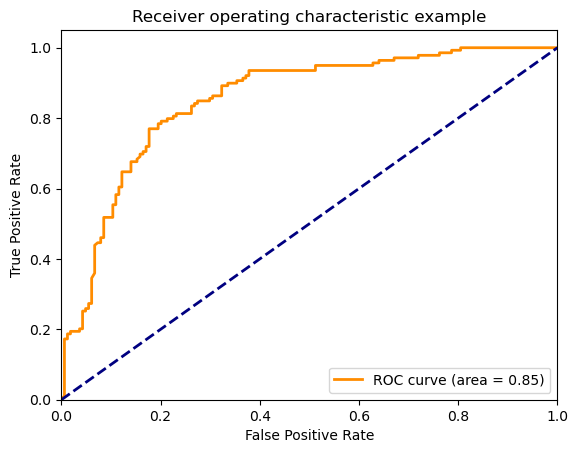

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito']) #a probabilidade predita para o evento

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

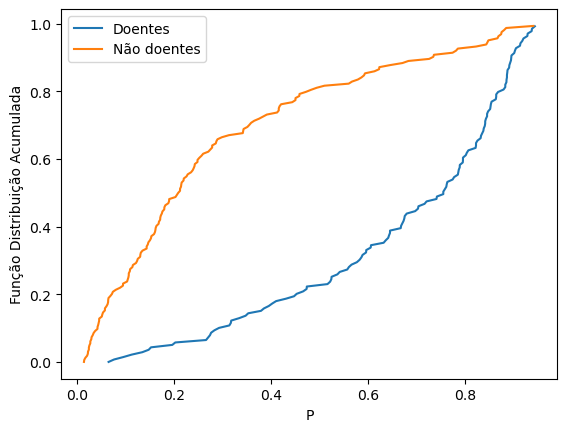

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'predito'] #Score da população 1
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Doentes')

score_pop2 = df.loc[df['flag_doente']!=1,'predito'] #Score da população 2
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não doentes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')


In [21]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc_ -1

#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 79.54%
KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [22]:
reglog = smf.logit(" flag_doente ~ C(sex) + C(cp, Treatment(4)) + trestbps + C(exang) + age"
                   , data=df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.456017
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                  0.3389
Time:                        16:42:17   Log-Likelihood:                -138.17
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.309e-27
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -6.2006      1.463     -4.238      0.000      -9.068      -3.333
C(sex)[T.1.0]                  1.7153      0.361      4.757      0.000       1.009       2.422
C(cp, Treatment(4))[T.1.0]    -2.0865      0.555     -3.760      0.000      -3.174      -0.999
C(cp, Treatment(4))[T.2.0]    -2.0863      0.472     -4.420      0.000      -3.011      -1.161
C(cp, Treatment(4))[T.3.0]    -2.0151      0.378     -5.327      0.000      -2.757      -1.274
C(exang)[T.1.0]                1.1819      0.341      3.462      0.001       0.513       1.851
trestbps                       0.0180      0.009      2.046      0.041       0.001       0.035
age                            0.0565      0.018      3.077      0.002       0.021       0.093
==============================================================================================
"""

In [23]:
df['predito'] = reglog.predict(df)

acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc_ -1

#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 78.22%
KS: 61.00% 
AUC: 86.57% 
GINI: 73.14%


- Ou inserir a variável `exang` no modelo, a acurácia reduziu pouco, mas os indicadores KS, AUC e GINI aumentaram.